# Code for image processing post segmentation

This notebook is made to select images with various channel intensities, crop and segment the nuclei to train an object classifier in ilastik.

In [3]:
import os 
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imshow
from skimage.measure import regionprops_table
from tqdm import tqdm
import random
import plotly.express as px
import plotly.graph_objects as go

Contenu du fichier HDF5: ['labels']
Type des données: <class 'numpy.ndarray'>
Forme des données: (3156, 3141)
Valeurs uniques: [    0     1     2 ... 38839 38840 38841]


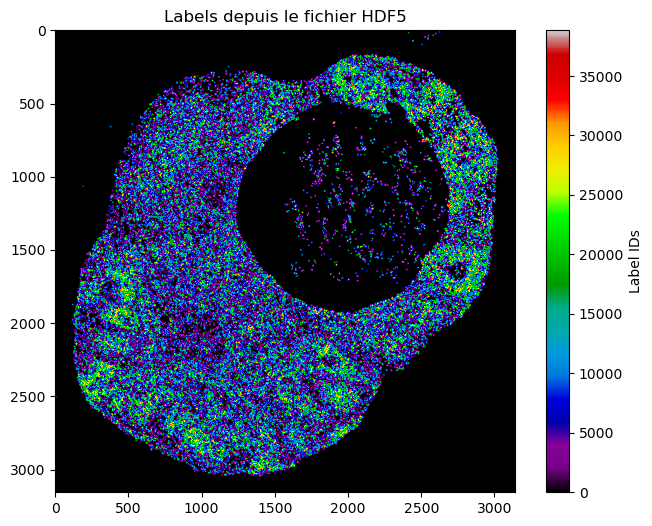

In [4]:

# Chemin vers ton fichier HDF5
file_path = "/Users/Julien/Downloads/test_pipeline/lbl/Pa_dQ_J70_SNd2T_20Xa_g1dt08_OG1_s1_labels.h5"

# Lire le fichier
with h5py.File(file_path, 'r') as f:
    # Vérifier les datasets disponibles
    print("Contenu du fichier HDF5:", list(f.keys()))

    # Lire les données (ici, on suppose que le dataset s'appelle 'labels')
    labels = f['labels'][:]

    # Afficher les informations
    print("Type des données:", type(labels))
    print("Forme des données:", labels.shape)
    print("Valeurs uniques:", np.unique(labels))

    # Afficher l'image
    plt.figure(figsize=(8, 6))
    plt.imshow(labels, cmap='nipy_spectral')
    plt.colorbar(label='Label IDs')
    plt.title("Labels depuis le fichier HDF5")
    plt.show()


Dimensions originales: 3156 x 3141


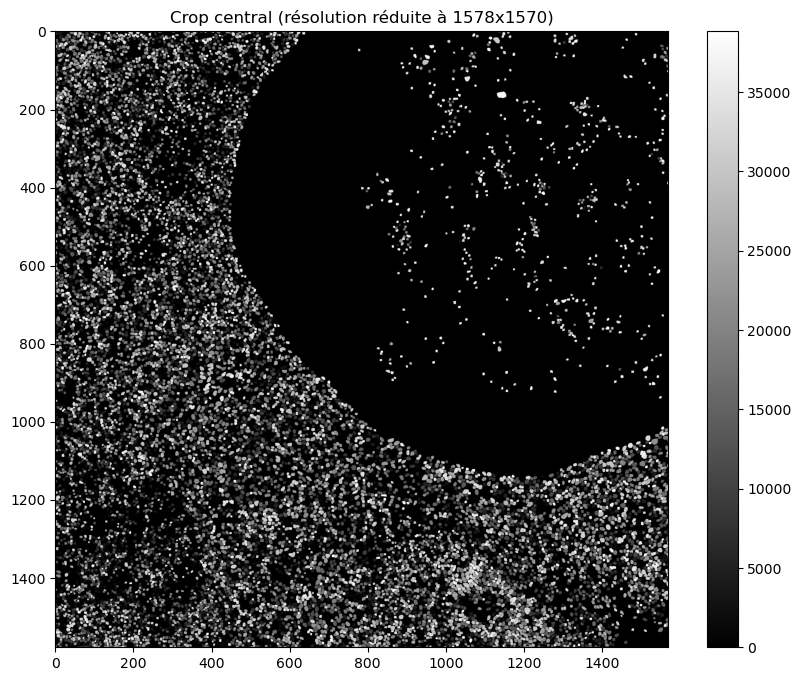

In [6]:
# Chemin vers ton fichier HDF5
file_path = "/Users/Julien/Downloads/test_pipeline/lbl/Pa_dQ_J70_SNd2T_20Xa_g1dt08_OG1_s1_labels.h5"


# Lire les données
with h5py.File(file_path, 'r') as f:
    labels = f['labels'][:]  # Charge toutes les données

# Dimensions de l'image
height, width = labels.shape
print(f"Dimensions originales: {height} x {width}")

# Crop de la moitié centrale (quart central si tu veux réduire encore plus)
crop_height = height // 2  # Moitié de la hauteur
crop_width = width // 2    # Moitié de la largeur

# Découpage (slicing) pour extraire le centre
# [début_haut:fin_haut, début_gauche:fin_gauche]
labels_cropped = labels[
    height // 4 : height // 4 + crop_height,  # Moitié centrale en Y
    width // 4 : width // 4 + crop_width      # Moitié centrale en X
]

# Afficher le crop
plt.figure(figsize=(10, 8))
plt.imshow(labels_cropped, cmap='gray')
plt.colorbar()
plt.title(f"Crop central (résolution réduite à {crop_height}x{crop_width})")
plt.show()

In [ ]:
# Define the different path of the folder containing your images to quantify
dir_img = '/Users/Julien/Downloads/test_pipeline'
dir_mask = dir_img + '/lbl'
dir_csv = dir_img

In [ ]:
# Get a list of all the files contained in the directories:
tif_img = [f for f in os.listdir(dir_img) if f.endswith(".tif") and not f.startswith("._")]
tif_mask = [f for f in os.listdir(dir_mask) if f.endswith(".tif") and not f.startswith("._")]

# print the number of images in each folder:
total_img = len(tif_img)
total_mask = len(tif_mask)
print(f' You have {total_img} images and {total_mask} masks')

# Verify that the number of images and masks are identical
if len(tif_img) != len(tif_mask):
    raise ValueError("Number of images and number of masks images do not correspond")

 You have 196 images and 196 masks


In [ ]:
# Extract the data from one random file to see the correpsonding matching
tif_files = [f for f in os.listdir(dir_img) if f.endswith(('.tif', '.tiff')) and not f.startswith("._")]
rfilename = random.choice(tif_files)

# Data extraction from the filename: this is specific to our usecase
parts = rfilename.split('_')
clone, dif, day, immuno, obj, imaging, og, s = parts[0], parts[1], parts[2], parts[3], parts[4], parts[5], parts[6], parts[7].split('.')[0]
print(f"clone: {clone}, dif: {dif}, day: {day}, immuno: {immuno}, obj: {obj}, imaging: {imaging}, og: {og}, s: {s}")

clone: H7, dif: dO, day: J70, immuno: SNd2T, obj: 20Xa, imaging: g1dt1, og: OG5, s: s2.tif


In [ ]:
# Create an empty list for storing the data 
df_list = []

# Loop through the TIFF files and display progress: the enumerate function also use the index to match the img with its mask
with tqdm(total=total_img, ncols=80) as pbar:
    for index, image_file in enumerate(tif_img, 1):

        # Print the filename and progress
        #print(f"Processing ({index}/{total_img}): {image_file}")

        # Check if the corresponding label file exists
        label_file = image_file.replace('.tif', '_labels.tif')
        if label_file not in tif_mask:
            raise ValueError(f"Label file {label_file} not found for image {image_file}")

        # Load the image and label
        image = imread(os.path.join(dir_img, image_file))
        label = imread(os.path.join(dir_mask, label_file))

        if image.shape[:2] != label.shape:
            raise ValueError(f"Label image {label_file} and your image {image_file} don't have the same shape")

        # Assuming you have a function to extract the measurements using regionprops_table
        properties = regionprops_table(label, intensity_image=image, properties=('label', 'area', 'mean_intensity'))
        
        # Data extraction from filename:
        parts = image_file.split('_')
        clone, dif, day, immuno, obj, imaging, og, s = parts[0], parts[1], parts[2], parts[3], parts[4], parts[5], parts[6], parts[7].split('.')[0]

        # Add additional information to the properties dictionary
        properties['Image_name'] = image_file
        properties['Clone'] = clone
        properties['Diff'] = dif
        properties['Day'] = day
        properties['Immuno'] = immuno
        properties['Objective'] = obj
        properties['Imaging'] = imaging 
        properties['Organoid'] = og
        properties['Slice'] = s

        # Append to the list
        df_list.append(pd.DataFrame(properties))

        # Update the progress bar
        pbar.update(1)

# Concatenate all the DataFrames into a single DataFrame
result_df = pd.concat(df_list, ignore_index=True)
result_df = result_df.reset_index(drop=True)
df = result_df[['Image_name', 'Clone', 'Diff', 'Day', 'Immuno', 'Objective', 'Imaging', 'Organoid', 'Slice', 'label', 'area', 'mean_intensity-0', 'mean_intensity-1', 'mean_intensity-2', 'mean_intensity-3']]


# end
print('\n Process finished')


100%|█████████████████████████████████████████| 196/196 [17:19<00:00,  5.31s/it]



 Process finished


In [27]:
df.head()

,Image_name,Clone,Diff,Day,Immuno,Objective,Imaging,Organoid,Slice,label,area,mean_intensity-0,mean_intensity-1,mean_intensity-2,mean_intensity-3
0,D11_dO_J70_SNd2T_20Xa_g1dt1_OG1_s2.tif,D11,dO,J70,SNd2T,20Xa,g1dt1,OG1,s2,1,34,1802.294118,66.441176,82.323529,78.823529
1,D11_dO_J70_SNd2T_20Xa_g1dt1_OG1_s2.tif,D11,dO,J70,SNd2T,20Xa,g1dt1,OG1,s2,2,34,2284.088235,107.323529,87.470588,63.058824
2,D11_dO_J70_SNd2T_20Xa_g1dt1_OG1_s2.tif,D11,dO,J70,SNd2T,20Xa,g1dt1,OG1,s2,3,33,1869.121212,88.212121,67.727273,57.696970
3,D11_dO_J70_SNd2T_20Xa_g1dt1_OG1_s2.tif,D11,dO,J70,SNd2T,20Xa,g1dt1,OG1,s2,4,43,2239.441860,64.627907,68.348837,66.651163
4,D11_dO_J70_SNd2T_20Xa_g1dt1_OG1_s2.tif,D11,dO,J70,SNd2T,20Xa,g1dt1,OG1,s2,5,28,1730.142857,61.357143,74.214286,76.928571


In [ ]:
# Dictionary of the clones and their corresponding genotypes: CHANGE IT ACCORDINGLY TO YOURS!!
genotypes = {
    'Pa':'WT/WT',
    'B6WT': 'WT/WT',
    'H6':'KO/KO',
    'C6':'KO/KO'
}

In [ ]:
# Calculate the mean intensity for each image of each channel
mean_intensity_0 = df.groupby(['Image_name', 'Clone'])['mean_intensity-0'].mean().reset_index()
mean_intensity_1 = df.groupby(['Image_name', 'Clone'])['mean_intensity-1'].mean().reset_index()
mean_intensity_2 = df.groupby(['Image_name', 'Clone'])['mean_intensity-2'].mean().reset_index()
mean_intensity_3 = df.groupby(['Image_name', 'Clone'])['mean_intensity-3'].mean().reset_index()


In [ ]:
# --- Step 2: Calculate mean intensities for ALL channels in one go ---
mean_intensities = result_df.groupby(['Image_name', 'Clone']).agg({
    'mean_intensity-0': 'mean',
    'mean_intensity-1': 'mean',
    'mean_intensity-2': 'mean',
    'mean_intensity-3': 'mean'
}).reset_index()

# Rename columns for clarity (optional)
mean_intensities = mean_intensities.rename(columns={
    'mean_intensity-0': 'Channel_1',
    'mean_intensity-1': 'Channel_2',
    'mean_intensity-2': 'Channel_3',
    'mean_intensity-3': 'Channel_4'
})

In [ ]:
# --- Step 3: Plot any channel by just changing the column name ---
# Example for Channel 1:
y = 'Channel_1' # to be modified

fig = px.scatter(
    mean_intensities,
    x='Clone',
    y=y,  # <-- Only this column name changes per channel
    color='Image_name',
    symbol='Image_name',
    opacity=0.7,
    title=f"Mean Intensity (Channel 1) by Clone"
)

# Overlay boxplot
box_trace = go.Box(
    x=mean_intensities['Clone'],
    y=mean_intensities[y],  # <-- Same column name here
    boxpoints='outliers',
    jitter=0.3,
    pointpos=-1.8,
    boxmean='sd',
    name='Distribution'
)
fig.add_trace(box_trace)

In [ ]:
# First select your channel of interest: here we focused on the 3rd channel ('mean_intensity_2')

# Create a scatter plot using plotly express
fig = px.scatter(mean_intensity_1, x='Clone', y='mean_intensity-1', color='Image_name', symbol='Image_name', opacity=0.7)

# Overlay a boxplot using plotly graph objects
box_trace = go.Box(x=mean_intensity_1['Clone'], y=mean_intensity_1['mean_intensity-1'], boxpoints='outliers', jitter=0.3, pointpos=-1.8, boxmean='sd')
fig.add_trace(box_trace)

# Set layout options
fig.update_layout(
    boxmode='overlay',
    boxgroupgap=0.2,
    boxgap=0.3
)

# Show the plot
fig.show()

In [ ]:
# automatic selection of images of different intensities per clones for training an object classifier later
for image in df

In [ ]:
# save the df you created with all the raw data. It should take in between 30 to 60 minutes.
df.to_csv(os.path.join(dir_csv, f'Raw_data_{dif}_{day}_{immuno}.csv'), index=False)